# Full SB2 Textbook Model

In [1]:
from os import path

import matplotlib.pyplot as plt
import numpy as np

from cobra import DictList

from mass import Simulation, plot_simulation
from mass.io import json, sbml

sim_options = {"method": "LSODA", "atol": 1e-15}
model_dir = path.realpath(path.join("../SB2/models", "."))
model_names = ["Glycolysis", "PentosePhosphatePathway",
               "AMPSalvageNetwork", "Hemoglobin", "PFK"]

## Model Construction 

In [2]:
glycolysis, ppp, ampsn, hemoglobin, PFK = list(map(
    lambda x: json.load_json_model(model_dir + "/SB2_" + x + ".json"),
    model_names))

# Create merged model of glycolysis and the pentose phosphate pathway
textbook = glycolysis.merge(ppp, inplace=False)
# Add in AMP salvage network
textbook.merge(ampsn, inplace=True)
# Remove uncessesary exchanges
textbook.remove_reactions([
    r for r in textbook.boundary 
    if r.id in ["SK_g6p_c", "DM_f6p_c", "DM_g3p_c", "DM_r5p_c",
                "DM_amp_c", "SK_amp_c", "SK_amp_c"]])

textbook.remove_boundary_conditions([
    met for met in textbook.boundary_conditions
    if met not in textbook.boundary_metabolites])
# Adjust stoichiometry and rate constant for PRPPS 
textbook.reactions.PRPPS.subtract_metabolites({
    textbook.metabolites.atp_c: -1,textbook.metabolites.adp_c: 2})
textbook.reactions.PRPPS.add_metabolites({
    textbook.metabolites.amp_c: 1})
# Add in hemoglobin module 
textbook.merge(hemoglobin, inplace=True, new_model_id="RBC")

Ignoring reaction 'SK_h_c' since it already exists.


Ignoring reaction 'SK_h2o_c' since it already exists.


mass/core/massmodel.py:1042 UserWarning: Skipping 'mM' for it already exists in the model.
mass/core/massmodel.py:1042 UserWarning: Skipping 'hr' for it already exists in the model.
Ignoring reaction 'ATPM' since it already exists.


Ignoring reaction 'SK_pi_c' since it already exists.


Ignoring reaction 'SK_amp_c' since it already exists.


Ignoring reaction 'SK_h_c' since it already exists.


Ignoring reaction 'SK_h2o_c' since it already exists.


Name,RBC
Memory address,0x01225c0588
Stoichiometric Matrix,48x53
Matrix Rank,44
Matrix Type,"dense, float64"
Number of Metabolites,48
Number of Initial Conditions,48
Number of Fixed Metabolites,0
Number of Reactions,53
Number of Forward Rate Constants,53
Number of Equilibrium Constants,53


## Steady State Determination

In [3]:
# Minspan paths
minspan_paths = np.array([
    [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-1, 0, 0, 0,-1, 1, 0, 0, 0, 0, 0,-2, 0, 0, 0, 0],
    [1,-2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 3, 3, 3, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 6, 6, 1, 0, 1, 0, 0, 0, 0, 0,13,-3, 3, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,-1, 0, 0, 0, 0, 0, 0, 0,-3, 0, 2, 2, 1, 0, 0,-1, 1, 0, 0, 0, 4, 0, 1, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,-1, 0, 0, 0, 0, 0, 0, 0,-3, 0, 2, 2, 1, 0, 0,-1, 0, 1, 0, 0, 4,-1, 1, 1, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,-1, 0, 0, 0, 0, 0, 0, 0,-3, 0, 2, 2, 1, 0, 0,-1, 0, 1, 0, 0, 4,-1, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,-1, 0, 0, 0, 0, 0, 0, 0,-2, 0, 0, 0, 0, 0, 0,-1, 0, 0, 1, 0, 0,-1, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0]
])

# Define new order for reactions
new_metabolite_order = ["glc__D_c", "g6p_c", "f6p_c", "fdp_c", "dhap_c","g3p_c", 
                        "_13dpg_c", "_3pg_c", "_2pg_c", "pep_c", "pyr_c", "lac__L_c", 
                        "_6pgl_c", "_6pgc_c", "ru5p__D_c",  "xu5p__D_c", "r5p_c", 
                        "s7p_c", "e4p_c", "ade_c", "adn_c", "imp_c", "ins_c", "hxan_c", 
                        "r1p_c", "prpp_c", "_23dpg_c","hb_c", "hb_1o2_c", "hb_2o2_c", 
                        "hb_3o2_c", "hb_4o2_c", "dhb_c", "nad_c", "nadh_c", "amp_c", 
                        "adp_c", "atp_c", "nadp_c", "nadph_c", "gthrd_c", "gthox_c", 
                        "pi_c", "h_c", "h2o_c", "co2_c", "nh3_c", "o2_c"]
if len(textbook.metabolites) == len(new_metabolite_order):
    textbook.metabolites = DictList(textbook.metabolites.get_by_any(new_metabolite_order))
# Define new order for metabolites
new_reaction_order = ["HEX1", "PGI", "PFK", "FBA", "TPI", "GAPD", "PGK", "PGM", 
                      "ENO", "PYK", "LDH_L", "G6PDH2r", "PGL", "GND", "RPE", 
                      "RPI", "TKT1", "TKT2", "TALA", "ADNK1", "NTD7", "ADA","AMPDA", 
                      "NTD11", "PUNP5", "PPM", "PRPPS", "ADPT", "ADK1", "DPGM", 
                      "DPGase", "HBDPG", "HBO1", "HBO2", "HBO3", "HBO4", "ATPM", 
                      "DM_nadh","GTHOr", "GSHR", "SK_glc__D_c", "SK_pyr_c", "SK_lac__L_c",
                      "SK_ade_c", "SK_adn_c", "SK_ins_c", "SK_hxan_c","SK_pi_c", 
                      "SK_h_c", "SK_h2o_c", "SK_co2_c", "SK_nh3_c", "SK_o2_c"]
if len(textbook.reactions) == len(new_reaction_order):
    textbook.reactions = DictList(textbook.reactions.get_by_any(new_reaction_order))
    
# Set independent fluxes to determine steady state flux vector
independent_fluxes = {textbook.reactions.SK_glc__D_c: 1.12, 
                      textbook.reactions.DM_nadh: 0.2*1.12, 
                      textbook.reactions.GSHR : 0.42, 
                      textbook.reactions.SK_ade_c: -0.014, 
                      textbook.reactions.ADA: 0.01,
                      textbook.reactions.SK_adn_c: -0.01, 
                      textbook.reactions.ADNK1: 0.12, 
                      textbook.reactions.SK_hxan_c: 0.097, 
                      textbook.reactions.DPGM: 0.441}

# Compute steady state fluxes
textbook.compute_steady_state_fluxes(minspan_paths, 
                                     independent_fluxes, 
                                     update_reactions=True);

# Calculation of PERCs
textbook.calculate_PERCs(update_reactions=True);
textbook.reactions.SK_o2_c.kf = 509726
textbook.reactions.HBDPG.kf =519613
textbook.reactions.HBO1.kf = 506935
textbook.reactions.HBO2.kf = 511077
textbook.reactions.HBO3.kf = 509243
textbook.reactions.HBO4.kf = 501595

## Steady State Validation

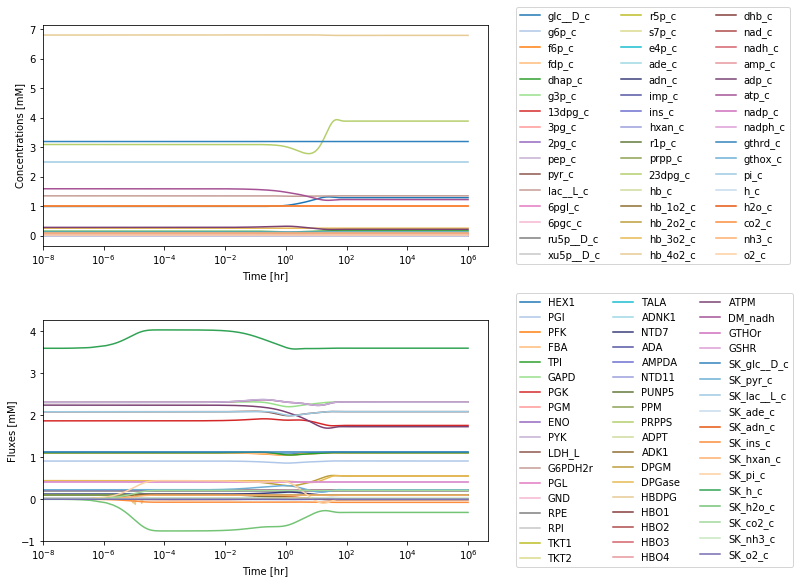

In [4]:
# Setup simulation object, ensure model is at steady state
sim = Simulation(textbook)
sim.find_steady_state_model(model=textbook, strategy="simulate", 
                            update_initial_conditions=True, 
                            update_reactions=True);

t0, tf = (0, 1e6)
conc_sol, flux_sol = sim.simulate_model(textbook, time=(t0, tf), **sim_options)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(11, 8), 
                               constrained_layout=True);

plot_simulation(conc_sol, ax=ax1, legend="right outside",
                plot_function="semilogx", xlabel="Time [hr]",
                ylabel="Concentrations [mM]");

plot_simulation(flux_sol, ax=ax2, legend="right outside",
                plot_function="semilogx", xlabel="Time [hr]",
                ylabel="Fluxes [mM]");

## Add PFK

In [5]:
textbook.remove_reactions(textbook.reactions.PFK)
textbook.merge(PFK, inplace=True, new_model_id="RBC_PFK")
textbook.custom_parameters.update({"kf_PFK": 3.07e5, "kf_PFK_A": 1.25e5, "kf_PFK_F": 5.05e7})

## Steady State Validation

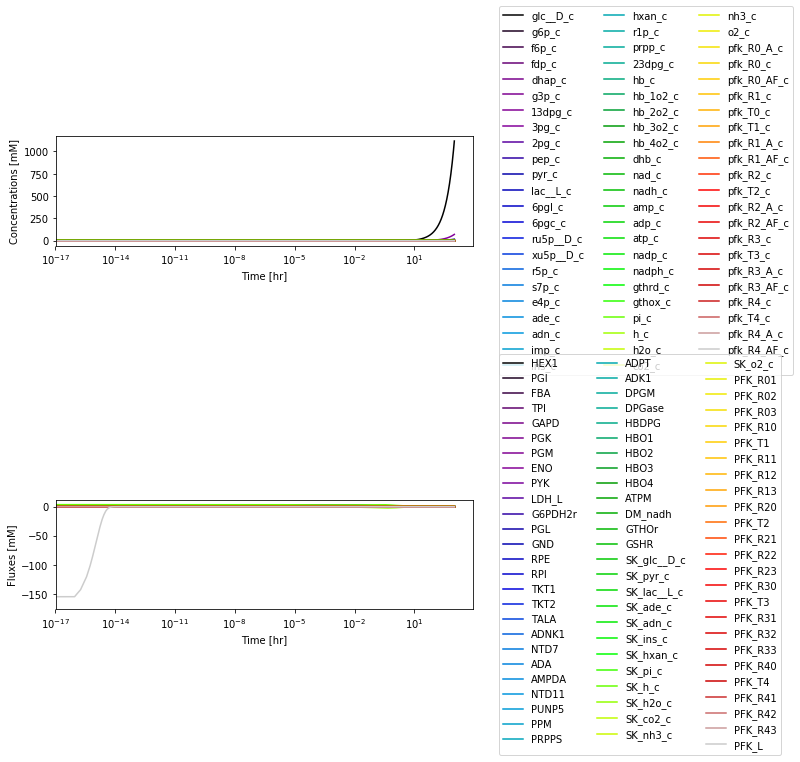

In [6]:
# Setup simulation object, ensure model is at steady state
sim = Simulation(textbook)
sim.find_steady_state_model(model=textbook, strategy="simulate", 
                            update_initial_conditions=True, 
                            update_reactions=True, **sim_options);

t0, tf = (0, 1e3)
conc_sol, flux_sol = sim.simulate_model(textbook, time=(t0, tf), **sim_options)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(11, 10), 
                               constrained_layout=True);

plot_simulation(conc_sol, ax=ax1, legend="right outside",
                plot_function="semilogx", xlabel="Time [hr]",
                ylabel="Concentrations [mM]");

plot_simulation(flux_sol, ax=ax2, legend="right outside",
                plot_function="semilogx", xlabel="Time [hr]",
                ylabel="Fluxes [mM]");

## Export

In [7]:
filepath = path.realpath(path.join("models", "SB2_Textbook"))

### Export using JSON

In [8]:
json.save_json_model(mass_model=textbook, filename=filepath + ".json")

### Export using SBML

In [9]:
sbml.write_sbml_model(mass_model=textbook, filename=filepath + ".xml")

adding fbc-V2 package extension
set fbc package extension required to false
set SBO term for modeling framework
create model
get fbc plugin for model
set fbc plugin strictness to true
set model id
set model meta id
create model parameter for 'kf_R_HEX1'
set parameter id for 'kf_R_HEX1'
set parameter value for 'kf_R_HEX1'
set parameter constant for 'kf_R_HEX1'
create model parameter for 'kf_R_PGI'
set parameter id for 'kf_R_PGI'
set parameter value for 'kf_R_PGI'
set parameter constant for 'kf_R_PGI'
create model parameter for 'kf_R_FBA'
set parameter id for 'kf_R_FBA'
set parameter value for 'kf_R_FBA'
set parameter constant for 'kf_R_FBA'
create model parameter for 'kf_R_TPI'
set parameter id for 'kf_R_TPI'
set parameter value for 'kf_R_TPI'
set parameter constant for 'kf_R_TPI'
create model parameter for 'kf_R_GAPD'
set parameter id for 'kf_R_GAPD'
set parameter value for 'kf_R_GAPD'
set parameter constant for 'kf_R_GAPD'
create model parameter for 'kf_R_PGK'
set parameter id for 'kf

create kinetic law for 'R_TPI'
set math on kinetic law for 'R_TPI'
create reaction for 'R_GAPD'
set reaction id for 'R_GAPD'
set reaction name for 'R_GAPD'
set reaction reversible for 'R_GAPD'
create specie reference M__13dpg_c for 'R_GAPD'
set specie reference id for 'M__13dpg_c'
set specie reference stoichiometry for 'M__13dpg_c'
set specie reference constant for 'M__13dpg_c'
create specie reference M_g3p_c for 'R_GAPD'
set specie reference id for 'M_g3p_c'
set specie reference stoichiometry for 'M_g3p_c'
set specie reference constant for 'M_g3p_c'
create specie reference M_h_c for 'R_GAPD'
set specie reference id for 'M_h_c'
set specie reference stoichiometry for 'M_h_c'
set specie reference constant for 'M_h_c'
create specie reference M_nad_c for 'R_GAPD'
set specie reference id for 'M_nad_c'
set specie reference stoichiometry for 'M_nad_c'
set specie reference constant for 'M_nad_c'
create specie reference M_nadh_c for 'R_GAPD'
set specie reference id for 'M_nadh_c'
set specie ref

create kinetic law for 'R_TKT2'
set math on kinetic law for 'R_TKT2'
create reaction for 'R_TALA'
set reaction id for 'R_TALA'
set reaction name for 'R_TALA'
set reaction reversible for 'R_TALA'
create specie reference M_e4p_c for 'R_TALA'
set specie reference id for 'M_e4p_c'
set specie reference stoichiometry for 'M_e4p_c'
set specie reference constant for 'M_e4p_c'
create specie reference M_f6p_c for 'R_TALA'
set specie reference id for 'M_f6p_c'
set specie reference stoichiometry for 'M_f6p_c'
set specie reference constant for 'M_f6p_c'
create specie reference M_g3p_c for 'R_TALA'
set specie reference id for 'M_g3p_c'
set specie reference stoichiometry for 'M_g3p_c'
set specie reference constant for 'M_g3p_c'
create specie reference M_s7p_c for 'R_TALA'
set specie reference id for 'M_s7p_c'
set specie reference stoichiometry for 'M_s7p_c'
set specie reference constant for 'M_s7p_c'
get fbc plugin for reaction for 'R_TALA'
create kinetic law for 'R_TALA'
set math on kinetic law for 

create kinetic law for 'R_GTHOr'
set math on kinetic law for 'R_GTHOr'
create reaction for 'R_GSHR'
set reaction id for 'R_GSHR'
set reaction name for 'R_GSHR'
set reaction reversible for 'R_GSHR'
create specie reference M_gthox_c for 'R_GSHR'
set specie reference id for 'M_gthox_c'
set specie reference stoichiometry for 'M_gthox_c'
set specie reference constant for 'M_gthox_c'
create specie reference M_gthrd_c for 'R_GSHR'
set specie reference id for 'M_gthrd_c'
set specie reference stoichiometry for 'M_gthrd_c'
set specie reference constant for 'M_gthrd_c'
create specie reference M_h_c for 'R_GSHR'
set specie reference id for 'M_h_c'
set specie reference stoichiometry for 'M_h_c'
set specie reference constant for 'M_h_c'
get fbc plugin for reaction for 'R_GSHR'
create kinetic law for 'R_GSHR'
set math on kinetic law for 'R_GSHR'
create reaction for 'R_SK_glc__D_c'
set reaction id for 'R_SK_glc__D_c'
set reaction name for 'R_SK_glc__D_c'
set reaction reversible for 'R_SK_glc__D_c'
cre

create kinetic law for 'R_PFK_R20'
set math on kinetic law for 'R_PFK_R20'
create reaction for 'R_PFK_T2'
set reaction id for 'R_PFK_T2'
set reaction name for 'R_PFK_T2'
set reaction reversible for 'R_PFK_T2'
create specie reference M_pfk_T2_c for 'R_PFK_T2'
set specie reference id for 'M_pfk_T2_c'
set specie reference stoichiometry for 'M_pfk_T2_c'
set specie reference constant for 'M_pfk_T2_c'
create specie reference M_atp_c for 'R_PFK_T2'
set specie reference id for 'M_atp_c'
set specie reference stoichiometry for 'M_atp_c'
set specie reference constant for 'M_atp_c'
create specie reference M_pfk_T1_c for 'R_PFK_T2'
set specie reference id for 'M_pfk_T1_c'
set specie reference stoichiometry for 'M_pfk_T1_c'
set specie reference constant for 'M_pfk_T1_c'
get fbc plugin for reaction for 'R_PFK_T2'
create kinetic law for 'R_PFK_T2'
set math on kinetic law for 'R_PFK_T2'
create reaction for 'R_PFK_R21'
set reaction id for 'R_PFK_R21'
set reaction name for 'R_PFK_R21'
set reaction revers

create kinetic law for 'R_PFK_L'
set math on kinetic law for 'R_PFK_L'

<?xml version="1.0" encoding="UTF-8"?>
<sbml xmlns="http://www.sbml.org/sbml/level3/version2/core" xmlns:fbc="http://www.sbml.org/sbml/level3/version1/fbc/version2" sboTerm="SBO:0000062" level="3" version="2" fbc:required="false">
  <model metaid="meta_RBC_PFK" id="RBC_PFK" fbc:strict="false">
    <listOfCompartments>
      <compartment id="c" name="Cytosol" constant="true"/>
      <compartment id="b" name="boundary" constant="true"/>
    </listOfCompartments>
    <listOfSpecies>
      <species id="M_glc__D_c" name="D-Glucose" compartment="c" initialConcentration="1" hasOnlySubstanceUnits="false" boundaryCondition="false" constant="false" fbc:charge="0" fbc:chemicalFormula="C6H12O6"/>
      <species id="M_g6p_c" name="D-Glucose 6-phosphate" compartment="c" initialConcentration="0.0486" hasOnlySubstanceUnits="false" boundaryCondition="false" constant="false" fbc:charge="-2" fbc:chemicalFormula="C6H11O9P"/>
      <sp